# Introduction to Time Series problem

## What can we forecast (predict)?
Read this blog: https://otexts.com/fpp2/what-can-be-forecast.html

## Get the data

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bit_predict_project/bitcoin_data_10_year.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2025-07-29,"118,699.0","118,054.8","119,261.0","117,467.4",50.57K,0.55%
2025-07-28,"118,053.9","119,402.7","119,788.2","117,426.5",61.81K,-1.13%
2025-07-27,"119,398.1","117,918.3","119,771.1","117,840.4",34.87K,1.26%
2025-07-26,"117,917.6","117,632.2","118,298.1","117,150.5",31.06K,0.24%
2025-07-25,"117,631.9","118,311.5","118,449.8","114,843.5",131.51K,-0.57%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2025-07-29 to 2015-07-29
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3654 non-null   object
 1   Open      3654 non-null   object
 2   High      3654 non-null   object
 3   Low       3654 non-null   object
 4   Vol.      3654 non-null   object
 5   Change %  3654 non-null   object
dtypes: object(6)
memory usage: 199.8+ KB


In [ ]:
len(df)

3654

In [ ]:
df['Price'] = df['Price'].str.replace(',', '', regex=False).astype(float)

In [ ]:
bitcoin_prices = df['Price']
bitcoin_prices = bitcoin_prices.sort_index(ascending=True)

In [ ]:
bitcoin_prices[:5]

,Price
Date,
2015-07-29,288.4
2015-07-30,287.0
2015-07-31,283.7
2015-08-01,280.5
2015-08-02,281.4


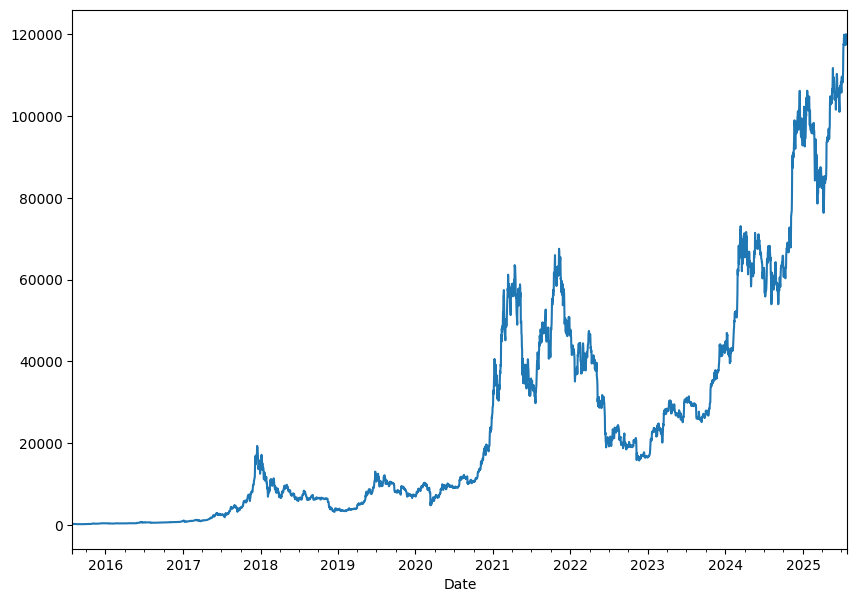

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.show()

In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.values

In [ ]:
timesteps[:5], prices[:5]

(array(['2015-07-29T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
        '2015-07-31T00:00:00.000000000', '2015-08-01T00:00:00.000000000',
        '2015-08-02T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([288.4, 287. , 283.7, 280.5, 281.4]))

## Splitting the data right way

In [ ]:
split_size = int(0.8 * len(prices))

In [ ]:
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

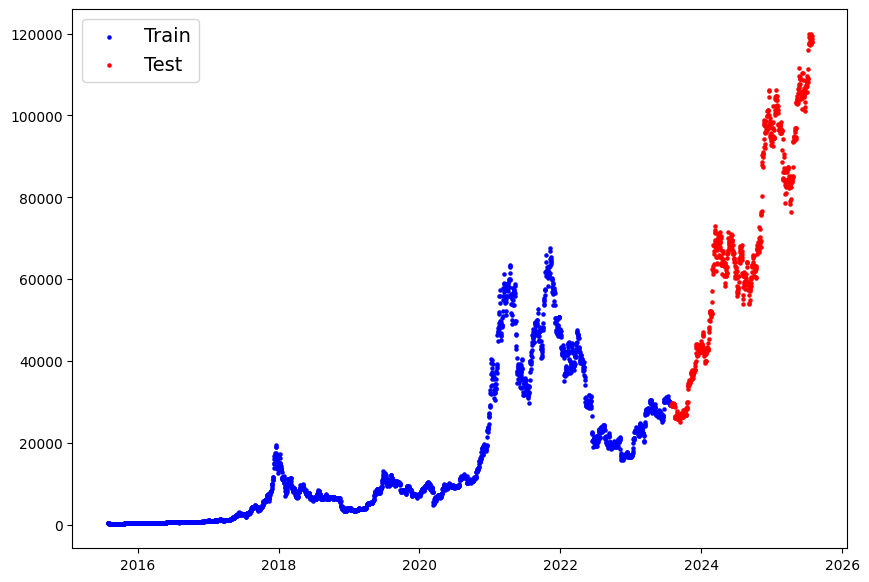

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, c='b', label='Train')
plt.scatter(X_test, y_test, s=5, c='r', label='Test')
plt.legend(fontsize=14);

## Series of model experimentation

### Model 0: Naive Forecast

In [ ]:
naive_forecast = y_test[:-1]

### Evaluation metric: MASE

In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  scale = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / scale

In [ ]:
def evaluate_metrics(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.losses.MeanAbsoluteError()
  mse = tf.keras.losses.MeanSquaredError()
  mape = tf.keras.losses.MeanAbsolutePercentageError()

  return {'mae': mae(y_true, y_pred).numpy(),
          'mse': mse(y_true, y_pred).numpy(),
          'rmse': tf.sqrt(mse(y_true, y_pred)).numpy(),
          'mape': mape(y_true, y_pred).numpy(),
          'mase': mean_absolute_scaled_error(y_true, y_pred).numpy()}

In [ ]:
naive_results = evaluate_metrics(y_test[1:], naive_forecast)

### Format our data: (Windowing our dataset)

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [ ]:
HORIZEN = 1
WINDOW = 7

In [ ]:
def get_labelled_window(x, horizen=HORIZEN):
  return x[:, :-horizen], x[:, -horizen:]

In [ ]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1, axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]], dtype=int32)>)

In [ ]:
def make_windows(x, windows=WINDOW, horizen=HORIZEN):
  window_step = np.expand_dims(np.arange(windows+horizen), axis=0)
  window_indices = window_step + np.expand_dims(np.arange(len(x)-(windows+horizen-1)), axis=0).T
  windowed_array = x[window_indices]
  windows, labels = get_labelled_window(windowed_array)
  return windows, labels

In [ ]:
windows, labels = make_windows(prices)
print(windows[0])
print(labels[0])

[288.4 287.  283.7 280.5 281.4 281.6 284.3]
[281.7]


### Turning windows into training and test set

In [ ]:
train_windows = windows[:split_size]
train_labels = labels[:split_size]

test_windows = windows[split_size:]
test_labels = labels[split_size:]

### Make a Modelling checkpoint

In [ ]:
import os

def create_model_checkpoint(model_name, save_path='model_experiments'):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name + ".keras"),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Windows=7, Horizon=1

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model_1 = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(HORIZEN, activation='linear')
], name='model_1_dense')

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_1_history = model_1.fit(train_windows,
                              train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 10474.4238 - mae: 10474.4238 - mse: 305992992.0000 - val_loss: 2619.3994 - val_mae: 2619.3994 - val_mse: 11604250.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1067.2450 - mae: 1067.2450 - mse: 3648952.0000 - val_loss: 2833.2480 - val_mae: 2833.2480 - val_mse: 13358374.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 744.0443 - mae: 744.0443 - mse: 1968337.8750 - val_loss: 1819.3529 - val_mae: 1819.3529 - val_mse: 6334926.5000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 633.3446 - mae: 633.3446 - mse: 1490999.2500 - val_loss: 1728.3762 - val_mae: 1728.3762 - val_mse: 5785771.0000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 614.4891 - mae: 614.4891 - mse: 1424983.8750 - val_loss: 1629.0468 - val_mae: 1629.0468 - val_mse: 5184577.0000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 571.0741 - mae: 571.0741 - mse: 1301989.0000 - val_loss: 1703.4271 - val_ma

In [ ]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense.keras')
model_1.evaluate(test_windows, test_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 880.8643 - mae: 880.8643 - mse: 1983572.0000


[1212.6861572265625, 1212.6861572265625, 3194892.75]

In [ ]:
model_1_preds = model_1.predict(test_windows)
model_1_preds

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[ 29086.059],
       [ 29090.617],
       [ 29194.182],
       [ 29722.434],
       [ 29639.113],
       [ 29498.258],
       [ 29435.936],
       [ 29443.824],
       [ 29335.309],
       [ 29417.514],
       [ 29236.77 ],
       [ 28797.836],
       [ 26894.332],
       [ 26061.547],
       [ 26002.555],
       [ 26140.424],
       [ 26112.857],
       [ 26029.084],
       [ 26387.48 ],
       [ 26233.55 ],
       [ 26093.73 ],
       [ 26024.457],
       [ 26099.023],
       [ 26132.438],
       [ 27531.07 ],
       [ 27414.316],
       [ 26176.941],
       [ 25796.07 ],
       [ 25834.338],
       [ 25972.09 ],
       [ 25836.41 ],
       [ 25786.957],
       [ 25769.018],
       [ 26199.209],
       [ 25979.283],
       [ 25922.13 ],
       [ 25852.414],
       [ 25266.242],
       [ 25743.047],
       [ 26174.918],
       [ 26529.676],
       [ 26627.316],
       [ 26598.812],
       [ 26567.047],
       [ 26755.426],
       [ 27177.05 ],
       [ 27172.629],
       [ 2667

In [ ]:
model_1_preds = tf.squeeze(model_1_preds)
len(model_1_preds)

724

In [ ]:
model_1_results = evaluate_metrics(tf.squeeze(test_labels), model_1_preds)
model_1_results

{'mae': np.float32(1212.6862),
 'mse': np.float32(3194892.8),
 'rmse': np.float32(1787.4263),
 'mape': np.float32(1.7640219),
 'mase': np.float32(0.99821746)}

In [ ]:
naive_results

{'mae': np.float32(1204.8705),
 'mse': np.float32(3165405.8),
 'rmse': np.float32(1779.1587),
 'mape': np.float32(1.7552955),
 'mase': np.float32(0.9986862)}

### Model 2: Windows=30, Horizon=1

In [ ]:
windows, labels = make_windows(prices, windows=30)

In [ ]:
len(windows), len(labels)

(3624, 3624)

In [ ]:
split_size = int(0.8 * len(windows))
train_windows = windows[:split_size]
train_labels = labels[:split_size]

test_windows = windows[split_size:]
test_labels = labels[split_size:]

In [ ]:
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2899, 2899, 725, 725)

In [ ]:
train_windows[:3], train_labels[:3]

(array([[288.4, 287. , 283.7, 280.5, 281.4, 281.6, 284.3, 281.7, 278. ,
         277.9, 258.6, 263.9, 263.3, 269. , 267.7, 263.4, 265. , 260.5,
         257.1, 257.1, 246.7, 226. , 234.7, 232.4, 229.5, 226.8, 211.4,
         220.5, 225. , 222.7],
        [287. , 283.7, 280.5, 281.4, 281.6, 284.3, 281.7, 278. , 277.9,
         258.6, 263.9, 263.3, 269. , 267.7, 263.4, 265. , 260.5, 257.1,
         257.1, 246.7, 226. , 234.7, 232.4, 229.5, 226.8, 211.4, 220.5,
         225. , 222.7, 231.6],
        [283.7, 280.5, 281.4, 281.6, 284.3, 281.7, 278. , 277.9, 258.6,
         263.9, 263.3, 269. , 267.7, 263.4, 265. , 260.5, 257.1, 257.1,
         246.7, 226. , 234.7, 232.4, 229.5, 226.8, 211.4, 220.5, 225. ,
         222.7, 231.6, 228.5]]),
 array([[231.6],
        [228.5],
        [228.4]]))

In [ ]:
model_2 = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(HORIZEN, activation='linear')
], name='model_2_dense')

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_2_history = model_2.fit(train_windows,
                              train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 6144.3794 - mae: 6144.3794 - mse: 136207648.0000 - val_loss: 3795.6355 - val_mae: 3795.6355 - val_mse: 24811830.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1107.9347 - mae: 1107.9347 - mse: 4054978.5000 - val_loss: 2276.1753 - val_mae: 2276.1753 - val_mse: 9411878.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 772.9720 - mae: 772.9720 - mse: 2130335.2500 - val_loss: 2293.5283 - val_mae: 2293.5283 - val_mse: 9332098.0000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 721.4699 - mae: 721.4699 - mse: 1913911.5000 - val_loss: 2016.5383 - val_mae: 2016.5383 - val_mse: 7393891.5000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 805.0252 - mae: 805.0252 - mse: 2278644.2500 - val_loss: 1994.2964 - val_mae: 1994.2964 - val_mse: 7182300.5000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 702.4105 - mae: 702.4105 - mse: 1775685.5000 - val_loss: 1854.8741 - val_mae: 

In [ ]:
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense.keras')
model_2.evaluate(test_windows, test_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 909.9109 - mae: 909.9109 - mse: 2081272.2500


[1264.1619873046875, 1264.1619873046875, 3408964.25]

In [ ]:
model_2_preds = model_2.predict(test_windows)
model_2_preds = tf.squeeze(model_2_preds)
model_2_results = evaluate_metrics(tf.squeeze(test_labels), model_2_preds)
model_2_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


{'mae': np.float32(1264.1621),
 'mse': np.float32(3408963.8),
 'rmse': np.float32(1846.3379),
 'mape': np.float32(1.8413028),
 'mase': np.float32(1.0420132)}

In [ ]:
model_1_results

{'mae': np.float32(1212.6862),
 'mse': np.float32(3194892.8),
 'rmse': np.float32(1787.4263),
 'mape': np.float32(1.7640219),
 'mase': np.float32(0.99821746)}

### Model 3: Window=30, Horizon=7

In [ ]:
windows, labels = make_windows(prices, windows=30, horizen=7)

split_size = int(0.8 * len(windows))
train_windows = windows[:split_size]
train_labels = labels[:split_size]

test_windows = windows[split_size:]
test_labels = labels[split_size:]

In [ ]:
model_3 = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7, activation='linear')
], name='model_3_dense')

model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_3_history = model_3.fit(train_windows,
                              train_labels,
                              epochs=100,
                              batch_size=128,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 9812.5137 - mae: 9812.5137 - mse: 311360512.0000 - val_loss: 6286.4116 - val_mae: 6286.4116 - val_mse: 70305784.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1520.1414 - mae: 1520.1414 - mse: 8083477.0000 - val_loss: 3382.0852 - val_mae: 3382.0852 - val_mse: 20857844.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1097.2163 - mae: 1097.2163 - mse: 4242741.5000 - val_loss: 2795.0405 - val_mae: 2795.0405 - val_mse: 14048198.0000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 914.3927 - mae: 914.3927 - mse: 3158385.5000 - val_loss: 2400.1648 - val_mae: 2400.1648 - val_mse: 10513416.0000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 843.9305 - mae: 843.9305 - mse: 2575291.5000 - val_loss: 2320.2402 - val_mae: 2320.2402 - val_mse: 9726082.0000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 826.8504 - mae: 826.8504 - mse: 2443103.2500 - val_loss: 2304.3550 - val_

In [ ]:
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense.keras')
model_3.evaluate(test_windows, test_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 983.1003 - mae: 983.1003 - mse: 2247236.2500


[1342.9346923828125, 1342.9346923828125, 3638132.75]

In [ ]:
model_3_preds = model_3.predict(test_windows)
model_3_results = evaluate_metrics(tf.squeeze(test_labels), tf.reduce_mean(model_3_preds, axis=1))
model_3_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


{'mae': np.float32(1312.1263),
 'mse': np.float32(3506928.0),
 'rmse': np.float32(1872.6793),
 'mape': np.float32(1.9211179),
 'mase': np.float32(1.0800712)}

### Model 4: Conv1D

In [ ]:
HORIZON = 1
WINDOW = 7

In [ ]:
windows, labels = make_windows(prices, windows=WINDOW, horizen=HORIZEN)

In [ ]:
split_size = int(0.8 * len(windows))
train_windows = windows[:split_size]
train_labels = labels[:split_size]

test_windows = windows[split_size:]
test_labels = labels[split_size:]

### Creating a Custom Layer

To address the `NameError` when loading the model, we will create a custom layer to replace the `Lambda` layer. This custom layer will perform the same operation of expanding the dimensions of the input tensor. By using a custom layer, we ensure that the model can be saved and loaded without issues.

In [ ]:
import tensorflow as tf

class ExpandDimsLayer(tf.keras.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super().__init__(**kwargs)
    self.axis = axis

  def call(self, inputs):
    return tf.expand_dims(inputs, axis=self.axis)

  def get_config(self):
    config = super().get_config()
    config.update({"axis": self.axis})
    return config

In [ ]:
model_4 = tf.keras.Sequential([
    ExpandDimsLayer(axis=-1),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    tf.keras.layers.Dense(HORIZEN, activation='linear')
], name='model_4_conv1d')

model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_4_history = model_4.fit(train_windows,
                              train_labels,
                              batch_size=128,
                              epochs=100,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 11172.0781 - mae: 11172.0781 - mse: 287451680.0000 - val_loss: 20257.5430 - val_mae: 20257.5430 - val_mse: 737368192.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4404.5981 - mae: 4404.5981 - mse: 64779304.0000 - val_loss: 13040.5615 - val_mae: 13040.5615 - val_mse: 453269152.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2708.3877 - mae: 2708.3877 - mse: 35732656.0000 - val_loss: 8616.9297 - val_mae: 8616.9297 - val_mse: 235011520.0000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2009.9432 - mae: 2009.9432 - mse: 20541292.0000 - val_loss: 6399.7500 - val_mae: 6399.7500 - val_mse: 139866880.0000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1560.5643 - mae: 1560.5643 - mse: 12947884.0000 - val_loss: 4878.0317 - val_mae: 4878.0317 - val_mse: 78323160.0000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1286.7828 - mae: 1286.7828 - mse: 8046599.0000 - val_l

In [ ]:
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1d.keras', custom_objects={'ExpandDimsLayer': ExpandDimsLayer})
model_4.evaluate(test_windows, test_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1707.2942 - mae: 1707.2942 - mse: 7015091.5000


[2313.621337890625, 2313.621337890625, 11123559.0]

In [ ]:
model_4_preds = model_4.predict(test_windows)
model_4_preds = tf.squeeze(model_4_preds)
model_4_results = evaluate_metrics(tf.squeeze(test_labels), tf.reduce_mean(model_4_preds, axis=1))
model_4_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


{'mae': np.float32(2069.8242),
 'mse': np.float32(8117845.5),
 'rmse': np.float32(2849.1833),
 'mape': np.float32(3.0845733),
 'mase': np.float32(1.7156241)}

### Model 5: LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(WINDOW,))
x = ExpandDimsLayer(axis=-1)(inputs)
x = tf.keras.layers.LSTM(128, activation='relu', return_sequences=True)(x)
x = tf.keras.layers.LSTM(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(HORIZEN, activation='linear')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_lstm')

model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_5_history = model_5.fit(train_windows,
                              train_labels,
                              batch_size=128,
                              epochs=100,
                              validation_data=(test_windows, test_labels),
                              callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 10582.9443 - mae: 10582.9443 - mse: 273267328.0000 - val_loss: 5681.7158 - val_mae: 5681.7158 - val_mse: 51475772.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1291.5199 - mae: 1291.5199 - mse: 5424002.5000 - val_loss: 6819.4917 - val_mae: 6819.4917 - val_mse: 86895544.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1349.8270 - mae: 1349.8270 - mse: 6708030.0000 - val_loss: 4478.3838 - val_mae: 4478.3838 - val_mse: 31615100.0000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1082.6184 - mae: 1082.6184 - mse: 3992881.0000 - val_loss: 2350.8054 - val_mae: 2350.8054 - val_mse: 10853581.0000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 817.4431 - mae: 817.4431 - mse: 2314406.2500 - val_loss: 2362.1479 - val_mae: 2362.1479 - val_mse: 10312778.0000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 914.2241 - mae: 914.2241 - mse: 3078995.2500 - val_loss: 2852.74

In [ ]:
model_5 = tf.keras.models.load_model('model_experiments/model_5_lstm.keras', custom_objects={'ExpandDimsLayer': ExpandDimsLayer})
model_5.evaluate(test_windows, test_labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 943.8574 - mae: 943.8574 - mse: 2182690.0000


[1316.4765625, 1316.4765625, 3582180.25]

In [ ]:
model_5_preds = model_5.predict(test_windows)
model_5_preds = tf.squeeze(model_5_preds)
model_5_results = evaluate_metrics(tf.squeeze(test_labels), model_5_preds)
model_5_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


{'mae': np.float32(1316.4766),
 'mse': np.float32(3582180.2),
 'rmse': np.float32(1892.6648),
 'mape': np.float32(1.9200882),
 'mase': np.float32(1.0911936)}

In [ ]:
naive_results

{'mae': np.float32(1204.8705),
 'mse': np.float32(3165405.8),
 'rmse': np.float32(1779.1587),
 'mape': np.float32(1.7552955),
 'mase': np.float32(0.9986862)}

## Make a multivariate time series Dataset

In [ ]:
# Let's add the bitcoin halving events to our dataset
block_reward_0 = 25
block_reward_1 = 12.5 # 2016 July 9
block_reward_2 = 6.25 # 2020 May 11
block_reward_3 = 3.125 # 2024 April 19

# Block reward date
block_reward_1_date = np.datetime64('2016-07-09')
block_reward_2_date = np.datetime64('2020-05-11')
block_reward_3_date = np.datetime64('2024-04-19')

In [ ]:
bitcoin_prices.head(), bitcoin_prices.tail()

(Date
 2015-07-29    288.4
 2015-07-30    287.0
 2015-07-31    283.7
 2015-08-01    280.5
 2015-08-02    281.4
 Name: Price, dtype: float64,
 Date
 2025-07-25    117631.9
 2025-07-26    117917.6
 2025-07-27    119398.1
 2025-07-28    118053.9
 2025-07-29    118699.0
 Name: Price, dtype: float64)

In [ ]:
block_reward_0_days = (block_reward_1_date - bitcoin_prices.index[0]).days
block_reward_1_days = (block_reward_2_date - bitcoin_prices.index[0]).days
block_reward_2_days = (block_reward_3_date - bitcoin_prices.index[0]).days

block_reward_0_days, block_reward_1_days, block_reward_2_days

(346, 1748, 3187)

In [ ]:
bitcoin_prices_block = bitcoin_prices.copy().to_frame()
bitcoin_prices_block['block_reward'] = None

In [ ]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2015-07-29,288.4,None
2015-07-30,287.0,None
2015-07-31,283.7,None
2015-08-01,280.5,None
2015-08-02,281.4,None


In [ ]:
bitcoin_prices_block.iloc[:block_reward_0_days, -1] = block_reward_0
bitcoin_prices_block.iloc[block_reward_0_days:block_reward_1_days, -1] = block_reward_1
bitcoin_prices_block.iloc[block_reward_1_days:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:, -1] = block_reward_3

In [ ]:
bitcoin_prices_block.head(), bitcoin_prices_block.tail()

(            Price block_reward
 Date                          
 2015-07-29  288.4           25
 2015-07-30  287.0           25
 2015-07-31  283.7           25
 2015-08-01  280.5           25
 2015-08-02  281.4           25,
                Price block_reward
 Date                             
 2025-07-25  117631.9        3.125
 2025-07-26  117917.6        3.125
 2025-07-27  119398.1        3.125
 2025-07-28  118053.9        3.125
 2025-07-29  118699.0        3.125)

<Axes: xlabel='Date'>

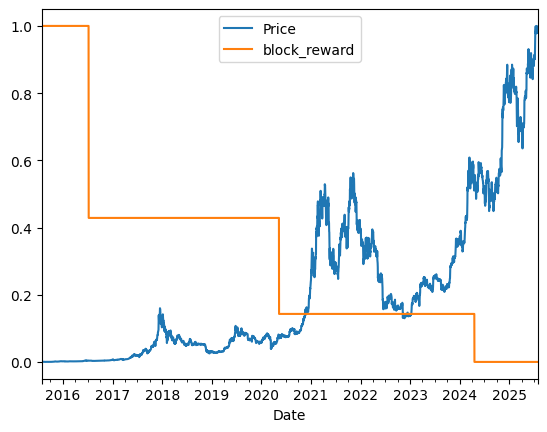

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaled_price_block_df = pd.DataFrame(MinMaxScaler().fit_transform(bitcoin_prices_block),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot()

In [ ]:
bitcoin_price_windowed = bitcoin_prices_block.copy()
for i in range(WINDOW):
  bitcoin_price_windowed[f'Price+{i+1}'] = bitcoin_price_windowed['Price'].shift(periods=i+1)

bitcoin_price_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2015-07-29,288.4,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,287.0,25,288.4,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,283.7,25,287.0,288.4,NaN,NaN,NaN,NaN,NaN
2015-08-01,280.5,25,283.7,287.0,288.4,NaN,NaN,NaN,NaN
2015-08-02,281.4,25,280.5,283.7,287.0,288.4,NaN,NaN,NaN
2015-08-03,281.6,25,281.4,280.5,283.7,287.0,288.4,NaN,NaN
2015-08-04,284.3,25,281.6,281.4,280.5,283.7,287.0,288.4,NaN
2015-08-05,281.7,25,284.3,281.6,281.4,280.5,283.7,287.0,288.4
2015-08-06,278.0,25,281.7,284.3,281.6,281.4,280.5,283.7,287.0


In [ ]:
X = bitcoin_price_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_price_windowed.dropna()['Price'].astype(np.float32)

In [ ]:
split_size = int(0.8 * len(X))

In [ ]:
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

### Model 6: Dense (multivariate time series)

In [ ]:
model_6 = Sequential([
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(HORIZEN, activation='linear')
], name='model_6_dense')

model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_6_history = model_6.fit(X_train,
                              y_train,
                              batch_size=128,
                              epochs=100,
                              validation_data=(X_test, y_test),
                              callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 8340.6172 - mae: 8340.6172 - mse: 212067040.0000 - val_loss: 6078.9189 - val_mae: 6078.9189 - val_mse: 47516988.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 967.1201 - mae: 967.1201 - mse: 2720857.0000 - val_loss: 2149.8271 - val_mae: 2149.8271 - val_mse: 8083716.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 608.6993 - mae: 608.6993 - mse: 1389045.2500 - val_loss: 1759.6077 - val_mae: 1759.6077 - val_mse: 5712018.5000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 541.4161 - mae: 541.4161 - mse: 1147780.5000 - val_loss: 1523.7955 - val_mae: 1523.7955 - val_mse: 4614965.5000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 526.6494 - mae: 526.6494 - mse: 1068792.3750 - val_loss: 2021.3583 - val_mae: 2021.3583 - val_mse: 7050814.5000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 556.5834 - mae: 556.5834 - mse: 1157991.6250 - val_loss: 1843.2452 - val_mae: 

In [ ]:
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense.keras')
model_6.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 865.8068 - mae: 865.8068 - mse: 1913836.0000


[1201.5811767578125, 1201.5811767578125, 3136427.5]

In [ ]:
model_6_preds = model_6.predict(X_test)
model_6_preds = tf.squeeze(model_6_preds)
model_6_results = evaluate_metrics(y_test, model_6_preds)
model_6_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


{'mae': np.float32(1201.5813),
 'mse': np.float32(3136427.2),
 'rmse': np.float32(1770.9961),
 'mape': np.float32(1.7551962),
 'mase': np.float32(0.9959598)}

In [ ]:
naive_results

{'mae': np.float32(1204.8705),
 'mse': np.float32(3165405.8),
 'rmse': np.float32(1779.1587),
 'mape': np.float32(1.7552955),
 'mase': np.float32(0.9986862)}

### Model 7: N-Beats algorithm

#### Building and testing the N-Beats block layer

In [ ]:
# Create NBeatBlock custom layer
@tf.keras.utils.register_keras_serializable()
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
sample_nbeats_block_layer = NBeatsBlock(input_size=WINDOW,
                                        theta_size=WINDOW + HORIZON,
                                        horizon=HORIZON,
                                        n_neurons=128,
                                        n_layers=4)

In [ ]:
sample_inputs = tf.expand_dims(tf.range(WINDOW) + 1, axis=0)
sample_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = sample_nbeats_block_layer(sample_inputs)
backcast, forecast

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[-0.50104475, -0.2940154 , -0.04953945, -0.71742606, -0.7756373 ,
          0.03199477, -0.24861537]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.4668934]], dtype=float32)>)

#### Prepare the data

In [ ]:
bitcoin_prices_nbeats = bitcoin_prices.copy().to_frame()
for i in range(WINDOW):
  bitcoin_prices_nbeats[f'Price+{i+1}'] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2015-07-29,288.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,287.0,288.4,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,283.7,287.0,288.4,NaN,NaN,NaN,NaN,NaN
2015-08-01,280.5,283.7,287.0,288.4,NaN,NaN,NaN,NaN
2015-08-02,281.4,280.5,283.7,287.0,288.4,NaN,NaN,NaN
2015-08-03,281.6,281.4,280.5,283.7,287.0,288.4,NaN,NaN
2015-08-04,284.3,281.6,281.4,280.5,283.7,287.0,288.4,NaN
2015-08-05,281.7,284.3,281.6,281.4,280.5,283.7,287.0,288.4
2015-08-06,278.0,281.7,284.3,281.6,281.4,280.5,283.7,287.0


In [ ]:
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_nbeats.dropna()['Price'].astype(np.float32)

In [ ]:
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

train_dataset = train_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

In [ ]:
# Setting up the hyperparameters
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

#### Building, Compiling, Testing the N-Beats algorithm

In [ ]:
# The following code is commented out because it takes a long time to run.
# The model has been pre-trained and is loaded in the next cell.
"""
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name='initialblock')
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE,), name='stack_input')
residuals, forecast = nbeats_block_layer(stack_input)

for i, _ in enumerate(range(N_STACKS - 1)): # first stack is already created
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                   theta_size=THETA_SIZE,
                                   horizon=HORIZON,
                                   n_neurons=N_NEURONS,
                                   n_layers=N_LAYERS,
                                   name=f'NBeatsBlock_{i}')(residuals)
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f'add_{i}')

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name='model_7_nbeats')

model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

model_7_history = model_7.fit(train_dataset,
                              epochs=N_EPOCHS,
                              validation_data=test_dataset,
                              verbose=0,
                              callbacks=[tf.keras.callbacks.EarlyStopping(patience=200,
                                                                          restore_best_weights=True),
                                         tf.keras.callbacks.ReduceLROnPlateau(patience=100,
                                                                              verbose=1)])
"""

"\nnbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,\n                                 theta_size=THETA_SIZE,\n                                 horizon=HORIZON,\n                                 n_neurons=N_NEURONS,\n                                 n_layers=N_LAYERS,\n                                 name='initialblock')\nstack_input = tf.keras.layers.Input(shape=(INPUT_SIZE,), name='stack_input')\nresiduals, forecast = nbeats_block_layer(stack_input)\n\nfor i, _ in enumerate(range(N_STACKS - 1)): # first stack is already created\n  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,\n                                   theta_size=THETA_SIZE,\n                                   horizon=HORIZON,\n                                   n_neurons=N_NEURONS,\n                                   n_layers=N_LAYERS,\n                                   name=f'NBeatsBlock_{i}')(residuals)\n  residuals = tf.keras.layers.subtract([residuals, backcast], name=f'subtract_{i}')\n  forecast

In [ ]:
model_7 = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Bit_predict_project/model_7_nbeats.keras',
                                     custom_objects={'NBeatsBlock': NBeatsBlock})

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'initialblock', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'NBeatsBlock_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'NBeatsBlock_1', however the layer does

In [ ]:
model_7_preds = model_7.predict(test_dataset)
model_7_preds = tf.squeeze(model_7_preds)
model_7_results = evaluate_metrics(y_test, model_7_preds)
model_7_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


{'mae': np.float32(1194.4141),
 'mse': np.float32(3134048.8),
 'rmse': np.float32(1770.3245),
 'mape': np.float32(1.7426935),
 'mase': np.float32(0.9900191)}

In [ ]:
naive_results

{'mae': np.float32(1204.8705),
 'mse': np.float32(3165405.8),
 'rmse': np.float32(1779.1587),
 'mape': np.float32(1.7552955),
 'mase': np.float32(0.9986862)}

In [ ]:
model_7.summary()

Model: "model_7_nbeats"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ stack_input         │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initialblock        │ [(None, 7),       │    796,168 │ stack_input[0][0] │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_0       │ [(None, 7),       │    796,168 │ initialblock[0][… │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_0          │ (None, 7)         │          0 │ initialblock[0][… │
│ (Subtract)          │                   │            │ NBeatsBlock_0[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_1       │ [(None, 7),       │    796,168 │ subtract_0[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 7)         │          0 │ subtract_0[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_2       │ [(None, 7),       │    796,168 │ subtract_1[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 7)         │          0 │ subtract_1[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_3       │ [(None, 7),       │    796,168 │ subtract_2[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_3          │ (None, 7)         │          0 │ subtract_2[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_4       │ [(None, 7),       │    796,168 │ subtract_3[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_4          │ (None, 7)         │          0 │ subtract_3[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_5       │ [(None, 7),       │    796,168 │ subtract_4[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_5          │ (None, 7)         │          0 │ subtract_4[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_6       │ [(None, 7),       │    796,168 │ subtract_5[0][0]  │
│ (NBeatsBlock)       │ (None, 1)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_6          │ (None, 7)         │          0 │ subtract_5[0][0], │
│ (Subtract)          │                   │            │ NBeatsBlock_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NBeatsBlock_7       │ [(None, 7),       │    796,168 │ subtract_6[0][0]

 Total params: 71,655,122 (273.34 MB)

 Trainable params: 23,885,040 (91.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,770,082 (182.23 MB)

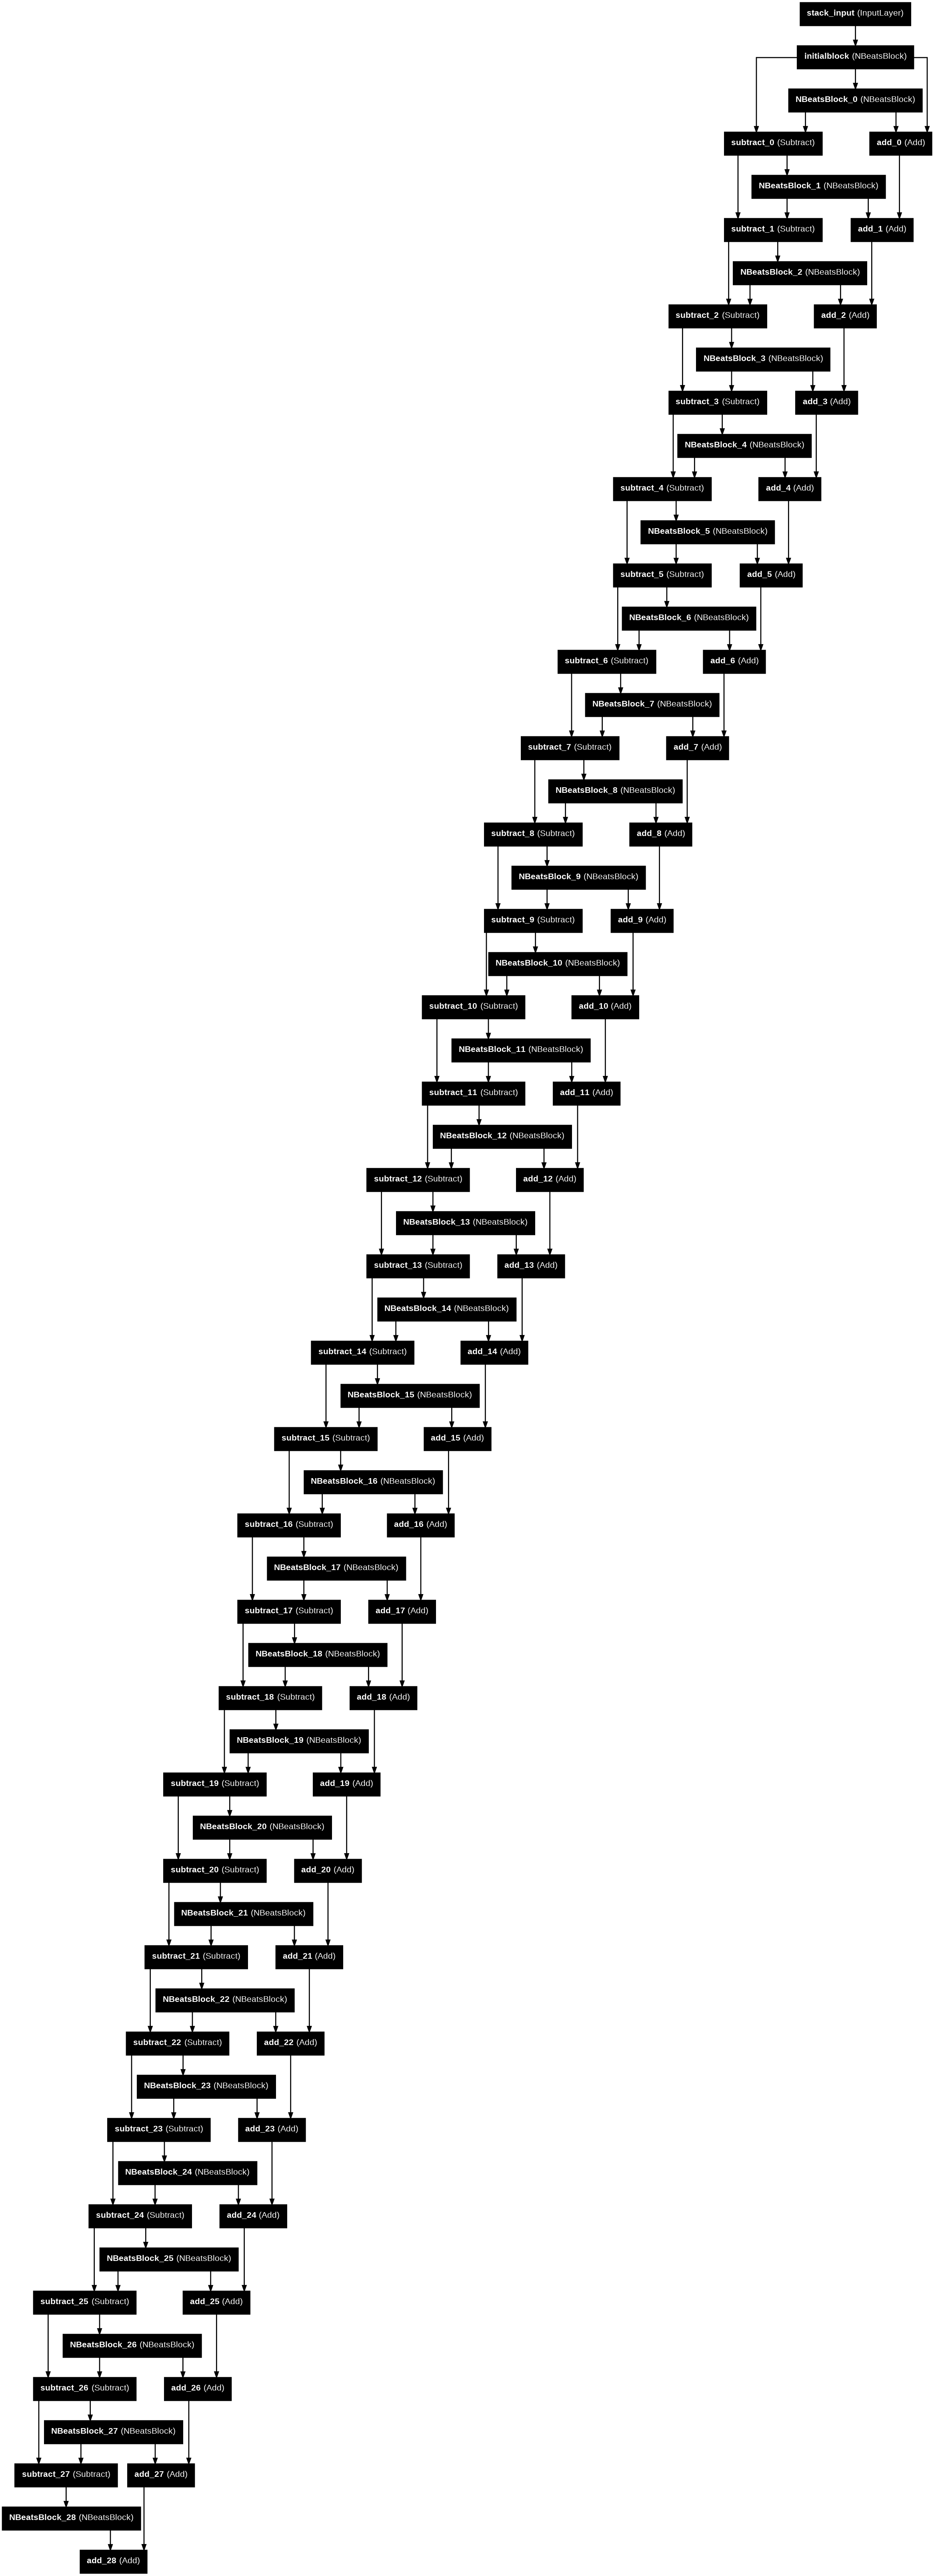

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_7,
           to_file='model_7.png',    # save as PNG
           show_layer_names=True,
           expand_nested=True,
           dpi=96)

### Model 8: Creating an emsemble (stacking different models together)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=['mae', 'mse', 'mape']):
  ensemble_models = []

  for i in range(num_iter):
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing {loss_function} for {num_epochs}, model number {i}')

      model = Sequential([
          Dense(128, kernel_initializer='he_normal', activation='relu'),
          Dense(64, kernel_initializer='he_normal', activation='relu'),
          Dense(horizon, activation='linear')
      ], name=f'model_{i}_{loss_function}')

      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse', 'mape'])

      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=200,
                                                           restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(patience=100,
                                                               verbose=1)])
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
ensemble_models = get_ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model by reducing mae for 1000, model number 0

Epoch 461: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000, model number 0

Epoch 225: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 325: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing mape for 1000, model number 0

Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mae for 1000, model number 1

Epoch 681: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing mse for 1000, model number 1
Optimizing model by reducing mape for 1000, model number 1

Epoch 394: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 501: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 601: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing

In [ ]:
ensemble_models

[<Sequential name=model_0_mae, built=True>,
 <Sequential name=model_0_mse, built=True>,
 <Sequential name=model_0_mape, built=True>,
 <Sequential name=model_1_mae, built=True>,
 <Sequential name=model_1_mse, built=True>,
 <Sequential name=model_1_mape, built=True>,
 <Sequential name=model_2_mae, built=True>,
 <Sequential name=model_2_mse, built=True>,
 <Sequential name=model_2_mape, built=True>,
 <Sequential name=model_3_mae, built=True>,
 <Sequential name=model_3_mse, built=True>,
 <Sequential name=model_3_mape, built=True>,
 <Sequential name=model_4_mae, built=True>,
 <Sequential name=model_4_mse, built=True>,
 <Sequential name=model_4_mape, built=True>]

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
emsemble_preds = make_ensemble_preds(ensemble_models, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [ ]:
emsemble_preds

<tf.Tensor: shape=(15, 730), dtype=float32, numpy=
array([[ 29290.895,  29253.504,  29639.752, ..., 117829.55 , 119438.6  ,
        118236.5  ],
       [ 29361.826,  29290.11 ,  29684.025, ..., 118069.125, 119240.78 ,
        118379.734],
       [ 29262.4  ,  29215.914,  29676.064, ..., 117804.266, 119280.31 ,
        118052.47 ],
       ...,
       [ 29264.549,  29257.047,  29685.812, ..., 117739.945, 119773.305,
        117817.19 ],
       [ 29264.03 ,  29251.76 ,  29698.52 , ..., 117670.875, 119501.39 ,
        117968.88 ],
       [ 29262.73 ,  29208.95 ,  29672.072, ..., 117760.805, 119234.18 ,
        118027.29 ]], dtype=float32)>

In [ ]:
y_test.shape

(730,)

In [ ]:
ensemble_mean = tf.reduce_mean(emsemble_preds, axis=0)
ensemble_mean.shape

TensorShape([730])

In [ ]:
ensemble_median = np.median(emsemble_preds, axis=0)
ensemble_median.shape

(730,)

In [ ]:
ensemble_results = evaluate_metrics(y_test, ensemble_mean)
ensemble_results

{'mae': np.float32(1196.749),
 'mse': np.float32(3134423.2),
 'rmse': np.float32(1770.4303),
 'mape': np.float32(1.7437307),
 'mase': np.float32(0.9919545)}

In [ ]:
ensemble_results = evaluate_metrics(y_test, ensemble_median)
ensemble_results

{'mae': np.float32(1195.2113),
 'mse': np.float32(3129700.0),
 'rmse': np.float32(1769.0958),
 'mape': np.float32(1.7413359),
 'mase': np.float32(0.9906799)}

### Getting the upper and lower bound
Utilizing the advantage of ensemble models, we'll predict the upper and lower intervals. This is better than getting a single prediction.

In [ ]:
def get_upper_lower(preds):
  std = tf.math.reduce_std(preds, axis=0)
  mean = tf.math.reduce_mean(preds, axis=0)
  upper = mean + 1.96 * std
  lower = mean - 1.96 * std
  return upper, lower

In [ ]:
upper, lower = get_upper_lower(emsemble_preds)

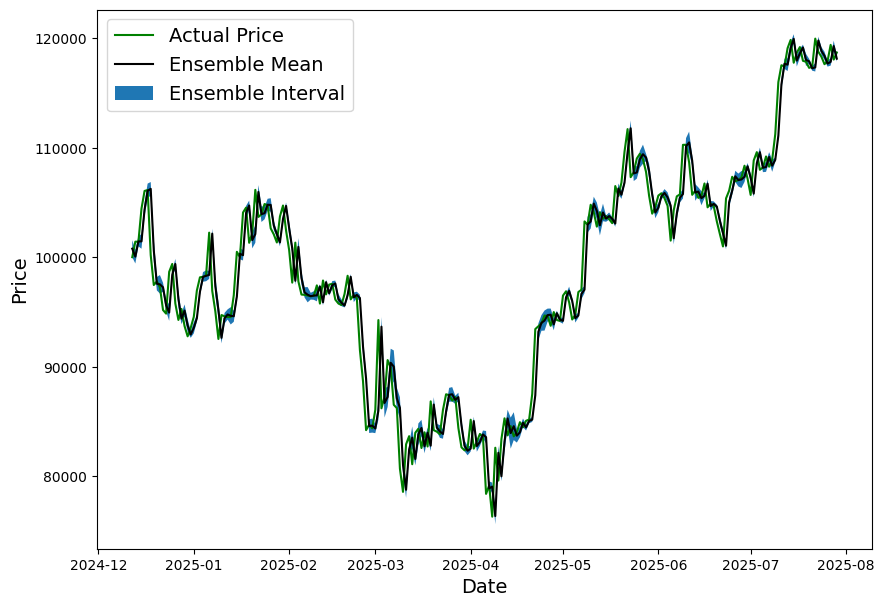

In [ ]:
# Plot the median of our ensemble preds along with the intervals
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], 'g', label='Actual Price')
plt.plot(X_test.index[offset:], ensemble_mean[offset:], 'k-', label='Ensemble Mean')
plt.fill_between(X_test.index[offset:], upper[offset:], lower[offset:], label='Ensemble Interval')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

### Model 9: Train a model on the full historical data to make predictions into the future


In [ ]:
X_all = bitcoin_prices_nbeats.dropna().drop('Price', axis=1).astype(np.float32).to_numpy()
y_all = bitcoin_prices_nbeats.dropna()['Price'].astype(np.float32).to_numpy()

In [ ]:
bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2015-07-29,288.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-30,287.0,288.4,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,283.7,287.0,288.4,NaN,NaN,NaN,NaN,NaN
2015-08-01,280.5,283.7,287.0,288.4,NaN,NaN,NaN,NaN
2015-08-02,281.4,280.5,283.7,287.0,288.4,NaN,NaN,NaN


In [ ]:
features_dataset = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset = tf.data.Dataset.from_tensor_slices(y_all)

dataset = tf.data.Dataset.zip((features_dataset, labels_dataset))
dataset = dataset.batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_9 = Sequential([
    Dense(128, kernel_initializer='he_normal', activation='relu'),
    Dense(64, kernel_initializer='he_normal', activation='relu'),
    Dense(HORIZEN, activation='linear')
], name='model_9_dense')

model_9.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

In [ ]:
model_9_history = model_9.fit(dataset,
                              epochs=1000,
                              verbose=0,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                                          patience=200,
                                                                          restore_best_weights=True),
                                         tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                                              patience=100,
                                                                              verbose=1)])


Epoch 119: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 596: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
INTO_FUTURE = 14

In [ ]:
def make_future_forecasts(values, model, into_future=INTO_FUTURE, window_size=WINDOW):
  future_forecast = []
  last_window = values[-1] # Get the last window from the data
  for _ in range(into_future):
    # The model expects a 1D array, so we pass last_window directly
    preds = model.predict(tf.expand_dims(last_window, axis=0))
    future_forecast.append(tf.squeeze(preds).numpy())
    # Append the prediction and remove the first element to create the new window
    last_window = np.append(last_window, future_forecast[-1])
    last_window = last_window[1:]
  return np.array(future_forecast)

In [ ]:
future_forecast = make_future_forecasts(X_all, model_9)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [ ]:
future_forecast

array([118054.8  , 119001.125, 118006.82 , 117800.71 , 118179.57 ,
       119109.34 , 119628.234, 117962.34 , 118675.94 , 118184.336,
       117894.516, 118087.08 , 119313.11 , 119398.016], dtype=float32)

In [ ]:
from datetime import timedelta

def get_future_dates(start_date, into_future=INTO_FUTURE):
  future_dates = []
  for i in range(into_future):
    future_dates.append(start_date + timedelta(days=i+1))
  return future_dates

In [ ]:
last_timestep = bitcoin_prices_nbeats.index[-1]
future_dates = get_future_dates(last_timestep)

In [ ]:
future_dates

[Timestamp('2025-07-30 00:00:00'),
 Timestamp('2025-07-31 00:00:00'),
 Timestamp('2025-08-01 00:00:00'),
 Timestamp('2025-08-02 00:00:00'),
 Timestamp('2025-08-03 00:00:00'),
 Timestamp('2025-08-04 00:00:00'),
 Timestamp('2025-08-05 00:00:00'),
 Timestamp('2025-08-06 00:00:00'),
 Timestamp('2025-08-07 00:00:00'),
 Timestamp('2025-08-08 00:00:00'),
 Timestamp('2025-08-09 00:00:00'),
 Timestamp('2025-08-10 00:00:00'),
 Timestamp('2025-08-11 00:00:00'),
 Timestamp('2025-08-12 00:00:00')]

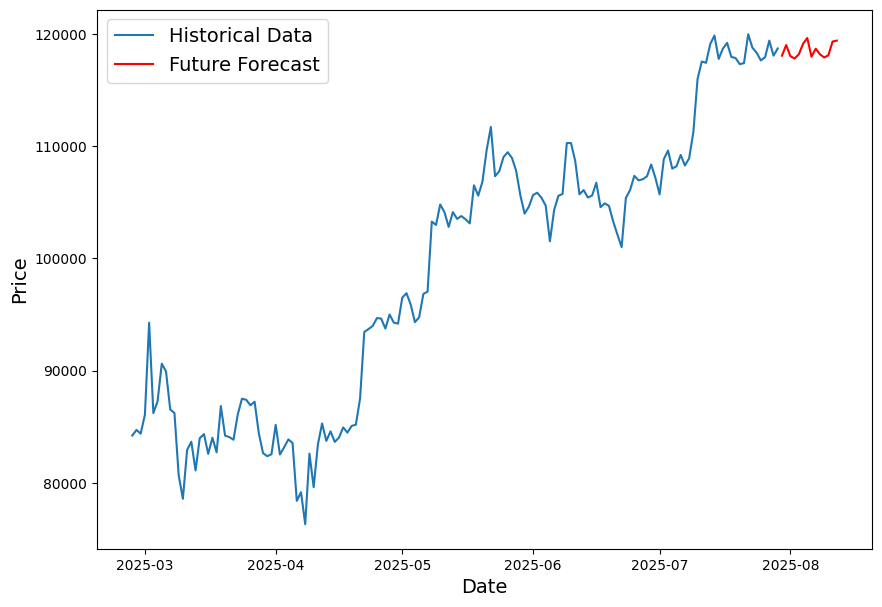

In [ ]:
# Get the last timestep from the data
last_timestep = bitcoin_prices_nbeats.index[-1]

# Get the future dates
future_dates = get_future_dates(last_timestep)

# Plot the future forecasts
offset=3500
plt.figure(figsize=(10, 7))
plt.plot(bitcoin_prices_nbeats.index[offset:], bitcoin_prices_nbeats['Price'][offset:], label='Historical Data')
plt.plot(future_dates, future_forecast, 'r', label='Future Forecast')
plt.legend(fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

### Model 10: Why forecasting is BS (the turkey problem)

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = bitcoin_prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

/tmp/ipython-input-2709139500.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_price_turkey[-1] = btc_price_turkey[-1] / 100
/tmp/ipython-input-2709139500.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  btc_price_turkey[-1] = btc_price_turkey[-1] / 100


In [ ]:
btc_price_turkey.tail()

,Price
Date,
2025-07-25,117631.90
2025-07-26,117917.60
2025-07-27,119398.10
2025-07-28,118053.90
2025-07-29,1186.99


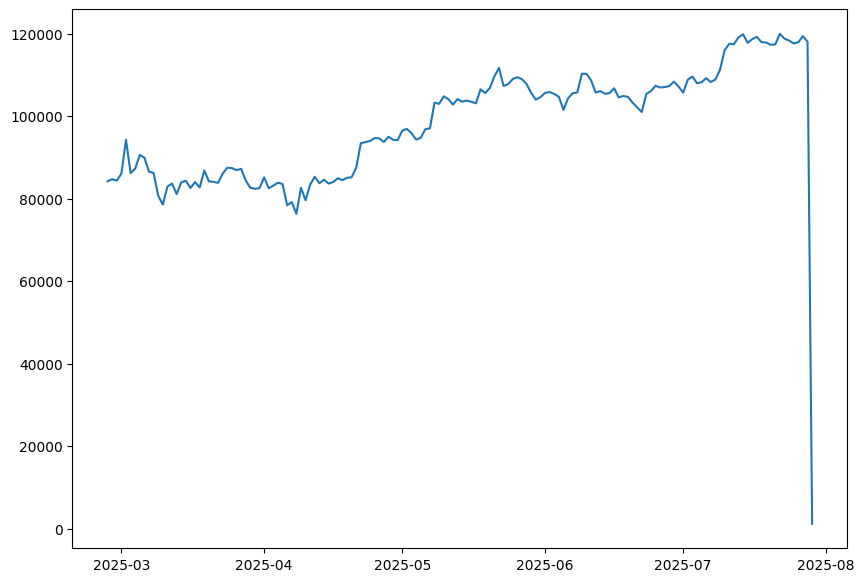

In [ ]:
offset = 3500
plt.figure(figsize=(10, 7))
plt.plot(btc_price_turkey.index[offset:], btc_price_turkey[offset:])

In [ ]:
windows, labels = make_windows(btc_price_turkey.values, windows=WINDOW, horizen=HORIZON)
split_size = int(0.8 * len(windows))
X_train, y_train = windows[:split_size], labels[:split_size]
X_test, y_test = windows[split_size:], labels[split_size:]

In [ ]:
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = 'turkey_model'
turkey_model.compile(loss='mae',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
turkey_model_history = turkey_model.fit(X_train,
                                       y_train,
                                       batch_size=128,
                                       epochs=100,
                                       validation_data=(X_test, y_test),
                                      callbacks=[create_model_checkpoint(model_name=turkey_model.name)])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6961.9341 - mae: 6961.9341 - mse: 152695584.0000 - val_loss: 6508.7412 - val_mae: 6508.7412 - val_mse: 69840416.0000
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1065.3357 - mae: 1065.3357 - mse: 3750395.2500 - val_loss: 2308.6567 - val_mae: 2308.6567 - val_mse: 27975626.0000
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 765.7150 - mae: 765.7150 - mse: 2232067.7500 - val_loss: 2262.0054 - val_mae: 2262.0054 - val_mse: 27110288.0000
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 726.6034 - mae: 726.6034 - mse: 2010384.7500 - val_loss: 2052.3560 - val_mae: 2052.3560 - val_mse: 25907208.0000
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 655.4196 - mae: 655.4196 - mse: 1654624.5000 - val_loss: 1988.2178 - val_mae: 1988.2178 - val_mse: 25652404.0000
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 671.3790 - mae: 671.3790 - mse: 1683240.1250 - val_loss: 1862.5242 - val

In [ ]:
turkey_model.evaluate(X_test, y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 875.5668 - mae: 875.5668 - mse: 3489379.7500


[1360.86279296875, 1360.86279296875, 21910160.0]

In [ ]:
turkey_preds = turkey_model.predict(X_test)
turkey_preds = tf.squeeze(turkey_preds)
turkey_results = evaluate_metrics(y_test, turkey_preds)
turkey_results

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


{'mae': np.float32(1360.8629),
 'mse': np.float32(21910162.0),
 'rmse': np.float32(4680.829),
 'mape': np.float32(15.250702),
 'mase': np.float32(21.984459)}

## Compare models

In [ ]:
# Create a pandas dataframe of model results
model_results = pd.DataFrame({'naive_model': naive_results,
                       'model_1': model_1_results,
                       'model_2': model_2_results,
                       'model_3': model_3_results,
                              'model_4': model_4_results,
                              'model_5': model_5_results,
                              'model_6': model_6_results,
                              'model_7': model_7_results,
                              'model_8': ensemble_results,
                              'model_10': turkey_results}).T

In [ ]:
model_results

,mae,mse,rmse,mape,mase
naive_model,1204.870483,3165405.75,1779.158691,1.755296,0.998686
model_1,1212.686157,3194892.75,1787.426270,1.764022,0.998217
model_2,1264.162109,3408963.75,1846.337891,1.841303,1.042013
model_3,1312.126343,3506928.00,1872.679321,1.921118,1.080071
model_4,2069.824219,8117845.50,2849.183350,3.084573,1.715624
model_5,1316.476562,3582180.25,1892.664795,1.920088,1.091194
model_6,1201.581299,3136427.25,1770.996094,1.755196,0.995960
model_7,1194.414062,3134048.75,1770.324463,1.742694,0.990019
model_8,1195.211304,3129700.00,1769.095825,1.741336,0.990680
model_10,1360.862915,21910162.00,4680.829102,15.250702,21.984459


<Axes: >

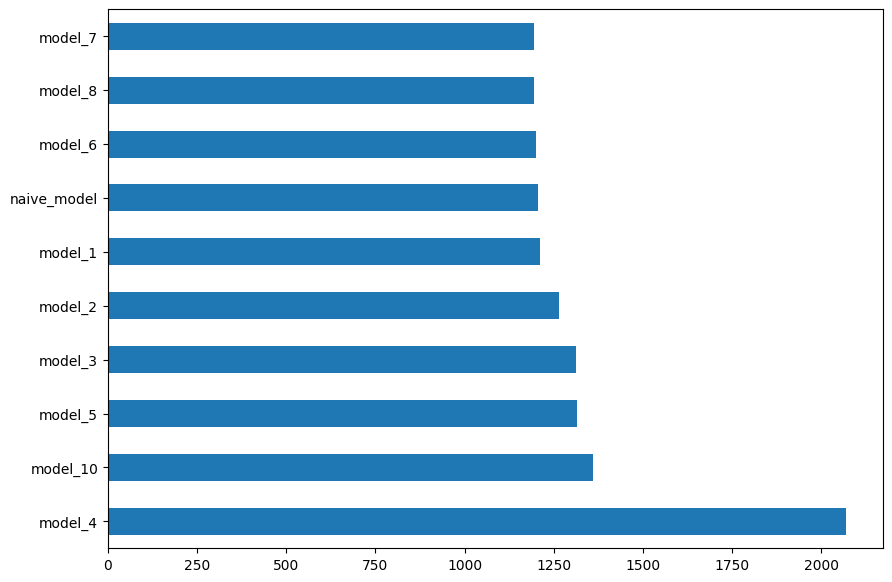

In [ ]:
# sort model results by MAE and plot them
model_results['mae'].sort_values(ascending=False).plot(kind='barh', figsize=(10, 7))